In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
df=pd.read_excel('C://Users//demey//Documents//2024-2025//Industry Project//Bariatric Project Study Data 2025_mod.xlsx', sheet_name='Sheet1')
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score
)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
core_X_data=df[['gender', 'age', 'height', 'weight', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt']].copy()
cm_cols= [col for col in df.columns if col.startswith('CM_')]

cm_data = df[cm_cols].fillna(0).astype(int)
cm_data
zero_only = [col for col in cm_data.columns if (cm_data[col] == 0).all()]
cm_data = cm_data.drop(columns=zero_only)

# finally, join the filtered CM_ data back into your core set
core_X_data = core_X_data.join(cm_data)
core_X_data.fillna(0, inplace=True)
print(core_X_data.isna().sum())  # should all be zero

# inspect result
print("Dropped CM columns:", zero_only)
print("Remaining columns in CM data:", cm_data.columns.tolist())

gender              0
age                 0
height              0
weight              0
bmi                 0
family_hist_cnt     0
chronic_meds_cnt    0
CM_AIDS             0
CM_ANEMDEF          0
CM_ARTH             0
CM_CHF              0
CM_DEPRESS          0
CM_DM               0
CM_DMCX             0
CM_HTN_C            0
CM_HYPOTHY          0
CM_LIVER            0
CM_OBESE            0
CM_PSYCH            0
CM_SMOKE            0
CM_APNEA            0
CM_CHOLSTRL         0
CM_OSTARTH          0
CM_HPLD             0
dtype: int64
Dropped CM columns: ['CM_ALCOHOL', 'CM_BLDLOSS', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DRUG', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_PARA', 'CM_PERIVASC', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS']
Remaining columns in CM data: ['CM_AIDS', 'CM_ANEMDEF', 'CM_ARTH', 'CM_CHF', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_OBESE', 'CM_PSYCH', 'CM_SMOKE', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OST

In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify types
num_features = core_X_data.select_dtypes(include=['int64', 'float64']).columns
cat_features = core_X_data.select_dtypes(include=['object', 'category']).columns

# Create transformers
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

# Apply transformation
X_prepared = preprocessor.fit_transform(core_X_data)


In [4]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

# Attach clusters to data
core_X_data['cluster'] = clusters


In [5]:
# Identify all complication-related columns
comp_cols = [col for col in df.columns if 'comp' in col.lower()]

# Create new dataset without the original complication columns
df_new = df.drop(columns=comp_cols)

# Add a single 'complication' column: 1 if any original comp column == 1, else 0
df_new['complication'] = (df[comp_cols] == 1).any(axis=1).astype(int)

# Display new dataset shape
print("New dataset shape (rows, columns):", df_new.shape)

# Show a sample of the new 'complication' column alongside the ID
# Show the first 10 rows of id and complication
print(df_new[['id', 'complication']].head(10))
print("First 15 column names:", df_new.columns.tolist())

New dataset shape (rows, columns): (344, 111)
        id  complication
0  45488.0             0
1      NaN             0
2  37462.0             1
3  40661.0             0
4      NaN             0
5  40699.0             0
6  38920.0             0
7  37827.0             0
8  47189.0             0
9      NaN             0
First 15 column names: ['doctor', 'procedure_category', 'hospitalDesc', 'hospital_wardDesc', 'days_since_admission', 'length_of_stay', 'gender', 'age', 'weight', 'height', 'bmi', 'family_hist_cnt', 'chronic_meds_cnt', 'cm_count', 'morbidity', 'CM_AIDS', 'CM_ALCOHOL', 'CM_ANEMDEF', 'CM_ARTH', 'CM_BLDLOSS', 'CM_CHF', 'CM_CHRNLUNG', 'CM_COAG', 'CM_DEPRESS', 'CM_DM', 'CM_DMCX', 'CM_DRUG', 'CM_HTN_C', 'CM_HYPOTHY', 'CM_LIVER', 'CM_LYMPH', 'CM_LYTES', 'CM_METS', 'CM_NEURO', 'CM_OBESE', 'CM_PARA', 'CM_PERIVASC', 'CM_PSYCH', 'CM_PULMCIRC', 'CM_RENLFAIL', 'CM_SMOKE', 'CM_TUMOR', 'CM_ULCER', 'CM_VALVE', 'CM_WGHTLOSS', 'CM_APNEA', 'CM_CHOLSTRL', 'CM_OSTARTH', 'CM_HPLD', 'emergency_

In [6]:
core_Y_data = df_new['complication'].copy()

Clusters: 2, Silhouette Score: 0.509
Clusters: 3, Silhouette Score: 0.269
Clusters: 4, Silhouette Score: 0.248
Clusters: 5, Silhouette Score: 0.269
Clusters: 6, Silhouette Score: 0.281
Clusters: 7, Silhouette Score: 0.172
Clusters: 8, Silhouette Score: 0.191
Clusters: 9, Silhouette Score: 0.201


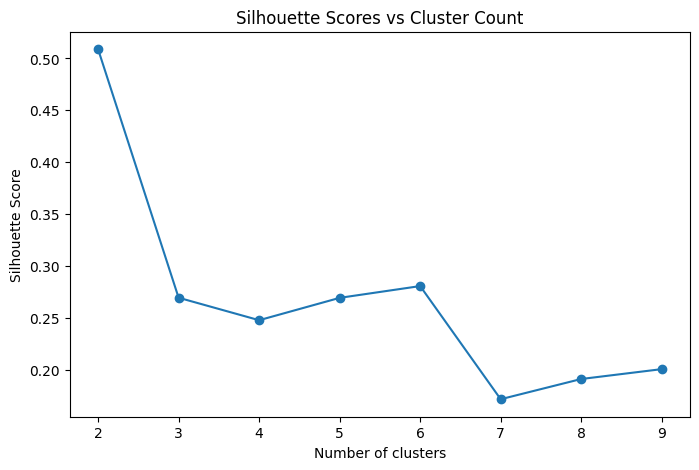

Best number of clusters: 2

Complication rates per cluster:
cluster
0    0.000000
1    0.099707
Name: complication, dtype: float64


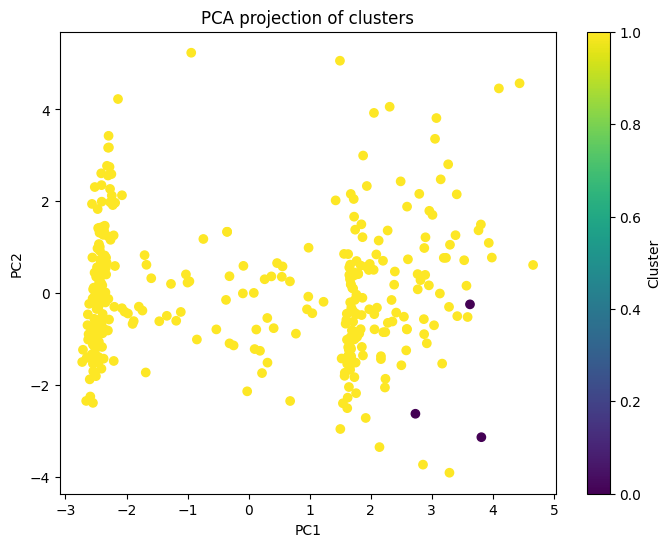

In [10]:
from sklearn.metrics import silhouette_score
# STEP 1 — Preprocessing

# Detect types
num_features = core_X_data.select_dtypes(include=['int64', 'float64']).columns
cat_features = core_X_data.select_dtypes(include=['object', 'category']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

X_prepared = preprocessor.fit_transform(core_X_data)

# STEP 2 — Try different number of clusters
silhouette_scores = []
cluster_range = range(2, 10)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_prepared)
    silhouette_avg = silhouette_score(X_prepared, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.3f}")

# STEP 3 — Plot Silhouette scores to pick best number
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores vs Cluster Count")
plt.show()

# STEP 4 — Pick the best number (let's say it's 5 for example)
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Best number of clusters: {best_n_clusters}")

# STEP 5 — Final clustering
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

core_X_data['cluster'] = clusters
core_X_data['complication'] = core_Y_data.values

# STEP 6 — Analyze complication rates
complication_rates = core_X_data.groupby('cluster')['complication'].mean()
print("\nComplication rates per cluster:")
print(complication_rates)

# STEP 7 — Visualize clusters in 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_prepared)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("PCA projection of clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()

In [11]:
# Get data for each cluster
cluster_0 = core_X_data[core_X_data['cluster'] == 0]
cluster_1 = core_X_data[core_X_data['cluster'] == 1]

# Compare means for numeric features
diff = cluster_0[num_features].mean() - cluster_1[num_features].mean()
print("Difference in means:")
print(diff.sort_values())

# For categorical features, check value counts
for cat in cat_features:
    print(f"\nCategorical feature: {cat}")
    print("Cluster 0:")
    print(cluster_0[cat].value_counts())
    print("Cluster 1:")
    print(cluster_1[cat].value_counts())


Difference in means:
weight             -16.230792
height              -4.603128
bmi                 -3.700381
chronic_meds_cnt    -1.029326
age                 -0.878788
family_hist_cnt     -0.134897
CM_DEPRESS          -0.076246
CM_HYPOTHY          -0.023460
CM_SMOKE            -0.023460
CM_ARTH             -0.008798
CM_CHF              -0.005865
CM_ANEMDEF          -0.002933
CM_PSYCH            -0.002933
CM_OBESE             0.184751
CM_HTN_C             0.448680
CM_HPLD              0.460411
CM_DM                0.466276
CM_OSTARTH           0.498534
CM_CHOLSTRL          0.533724
CM_DMCX              0.583578
CM_LIVER             1.101662
CM_APNEA             1.501466
CM_AIDS              2.330401
dtype: float64

Categorical feature: gender
Cluster 0:
gender
Female    3
Name: count, dtype: int64
Cluster 1:
gender
Female    290
Male       51
Name: count, dtype: int64


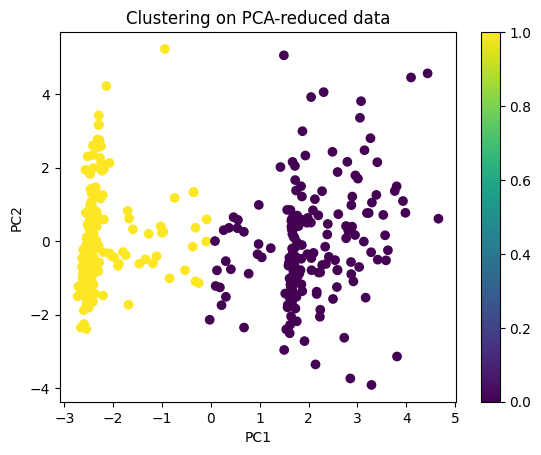

In [12]:
from sklearn.decomposition import PCA

# Use PCA-reduced data for clustering
X_pca = PCA(n_components=2).fit_transform(X_prepared)

# Apply KMeans on PCA
kmeans_pca = KMeans(n_clusters=2, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)

# Plot result
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='viridis')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clustering on PCA-reduced data")
plt.colorbar()
plt.show()


In [13]:
core_X_data['pca_cluster'] = clusters_pca
core_X_data['complication'] = core_Y_data.values


In [14]:
# Compute complication rate per cluster
complication_rates_pca = core_X_data.groupby('pca_cluster')['complication'].mean()

print("Complication rates per PCA-based cluster:")
print(complication_rates_pca)

# (Optional) also see how many patients per cluster
cluster_sizes_pca = core_X_data['pca_cluster'].value_counts()
print("\nNumber of patients per PCA-based cluster:")
print(cluster_sizes_pca)


Complication rates per PCA-based cluster:
pca_cluster
0    0.078652
1    0.120482
Name: complication, dtype: float64

Number of patients per PCA-based cluster:
pca_cluster
0    178
1    166
Name: count, dtype: int64
